# Deep Convolutional Generative Adversarial Network (DCGAN)
### Generator và Discriminator đều đc xây dựng bằng mô hình CNN vs 2 layers chính là:
* Convolutional layer
* Transposed Convolutional layer

## Generator
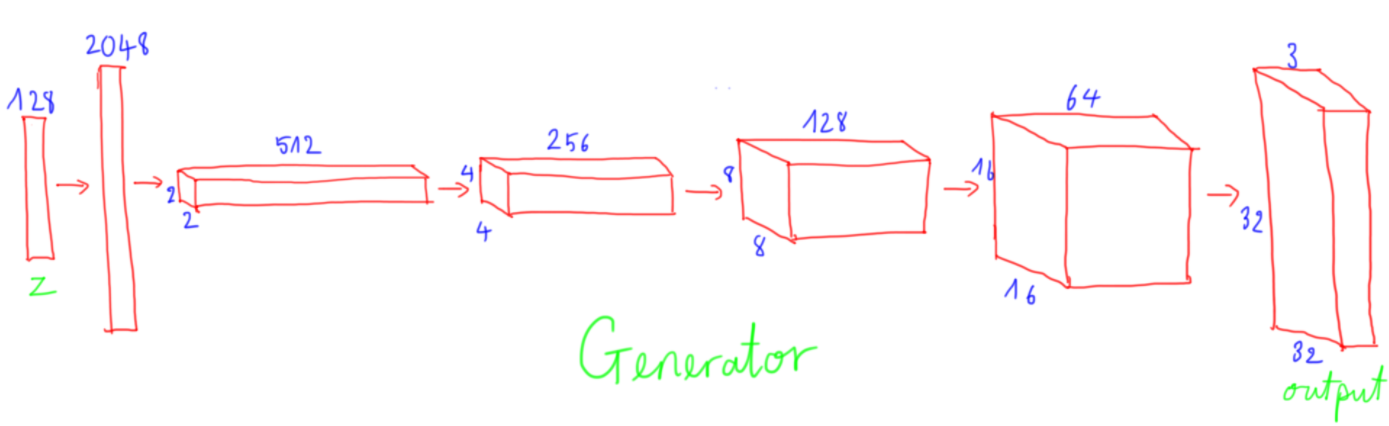

|                       Layers                      |          Input2Output (shape)          |
|:-------------------------------------------------:|:--------------------------------------:|
|              Dense (fully-connected)              |    (128, 1) $\rightarrow$ (2048, 1)    |
|                      Reshape                      |   (2048, 1) $\rightarrow$ (2, 2, 512)  |
| Transposed convolution (stride = 2, kernel = 256) |  (2, 2, 512) $\rightarrow$ (4, 4, 256) |
| Transposed convolution (stride = 2, kernel = 128) |  (4, 4, 256) $\rightarrow$ (8, 8, 128) |
|  Transposed convolution (stride = 2, kernel = 64) | (8, 8, 128) $\rightarrow$ (16, 16, 64) |
|  Transposed convolution (stride = 2, kernel = 3)  | (16, 16, 64) $\rightarrow$ (32, 32, 3) |

## Transposed Convolution
* Transposed Convolution hay Deconvolution coi là phép toán ngược của Convolution:
    * Ở Convolution thì $~~~~~~~~~~~~~$ stride > 1 làm *giảm* kích thước ảnh
    * Transposed Convolution thì stride > 1 làm *tăng* kích thước ảnh
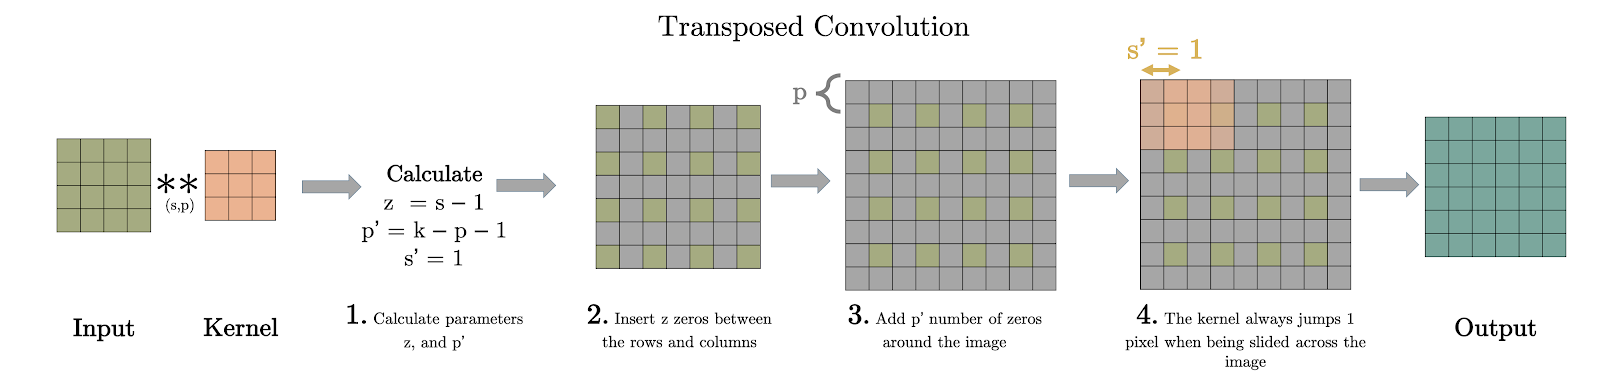
* Ở hình trên, ta thấy các bước thực hiện Transposed Convolution
    1. Tính tham số $z$ và $p'$ theo công thức:
    > $z=s-1=1\\p'=k-p-1=1\\s'=1$
    2. Thêm $z$ vào giữa các hàng và cột
    3. Padding thêm $p'$ các padding zeros
    4. $s'$ quyết định bước nhảy của kernel
* Phần tính $z$ và $p'$ mục đích để thực hiện Convolution trên Output vs $s$ và $p$ sẽ ra được Input

## Discriminator
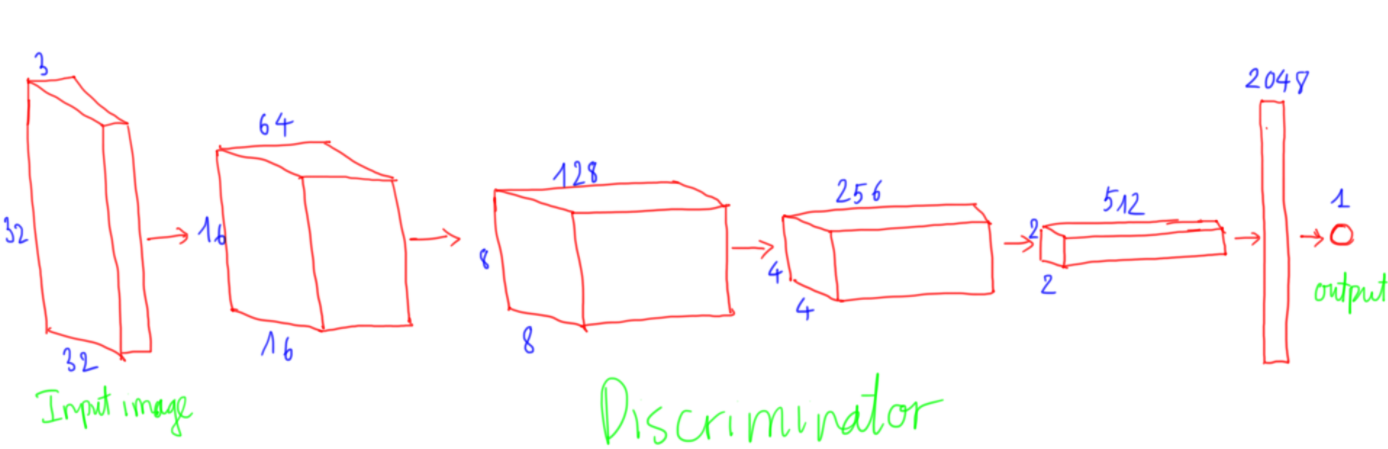

| Convolution (stride = 2) | (32, 32, 3) $\rightarrow$ (16, 16, 64) |
|:------------------------:|:--------------------------------------:|
| Convolution (stride = 2) | (16, 16, 64) $\rightarrow$ (8, 8, 128) |
| Convolution (stride = 2) |  (8, 8, 128) $\rightarrow$ (4, 4, 256) |
| Convolution (stride = 2) |  (4, 4, 256) $\rightarrow$ (2, 2, 512) |
|          Flatten         |    (2, 2, 512) $\rightarrow$ (2048,)   |
|  Dense (fully-connected) |         (2048,) $\rightarrow$ 1        |

### Loss function giống với GAN thông thường
> $\Large{\displaystyle \min_G\max_DV(G, D)=\mathbb{E}_{x\in p_{data}(x)}[\log D(x)]+\mathbb{E}_{z\in p_{z}(z)}[\log (1-D(G(z)))]}$
    
> Trong đó $\mathbb{E}$ là kỳ vọng (hiểu là lấy trung bình của tất cả dữ liệu)

### Tips build và train DCGAN
* Dùng ReLU trên toàn bộ Generator trừ phần Output layer mà dùng tanh và scale ảnh Input về (-1, 1) sẽ cho kết quả tốt hơn sigmoid
* Dùng LeakyReLU trong Discriminator
* Thay thế maxpooling bằng Convolution vs stride = 2
* Dùng Transposed Convolution để unsampling
* Dùng batch norm từ Output layer trong Generator và Input layer trong Discriminator

In [ ]:
! mkdir Images1
! ls

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, math, os
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.compat.v1.keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from tqdm.notebook import tqdm

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# value of pixel from -1 to 1
X_train = 2 * X_train - 1
X_test = 2 * X_test - 1

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
def build_generator(z_dim = 128, n_filter = 64):
    init = RandomNormal(stddev = 0.02)
    
    G = Sequential()
    # (32, 32, 3) -> (2048,)
    G.add(Dense(2 * 2 * n_filter * 8, input_shape = (z_dim,), kernel_intializer = init))
    # (2048,) -> (2, 2, 512)
    G.add(Reshape((2, 2, n_filter * 8)))
    G.add(BatchNormalization())
    G.add(LeakyReLU(alpha = 0.2))
    # (2, 2, 512) -> (4, 4, 256)
    G.add(Conv2DTranspose(n_filter * 4, kernel_size = (5, 5), strides = 2, padding = 'same', kernel_intializer = init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(alpha = 0.2))
    # (4, 4, 256) -> (8, 8, 128)
    G.add(Conv2DTranspose(n_filter * 2, kernel_size = (5, 5), strides = 2, padding = 'same', kernel_intializer = init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(alpha = 0.2))
    # (8, 8, 128) -> (16, 16, 64)
    G.add(Conv2DTranspose(n_filter, kernel_size = (5, 5), strides = 2, padding = 'same', kernel_intializer = init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(alpha = 0.2))
    # (16, 16, 64) -> (32, 32, 3)
    G.add(Conv2DTranspose(3, kernel_size = (5, 5), strides = 2, padding = 'same', kernel_intializer = init))
    G.add(BatchNormalization())
    G.add(Activation('tanh'))
    
    print('-' * 15 + 'Generator summary' + '-' * 15)
    G.summary()
    return G

In [5]:
def build_discriminator(ip = (32, 32, 3), n_filter = 64):
    init = RandomNormal(stddev = 0.02)
    
    D = Sequential()
    # (32, 32, 3) -> (16, 16, 64)
    D.add(Conv2D(n_filter, input_shape = ip, kernel_size = (5, 5), strides = 2, padding = 'same', kernel_intializer = init))
    D.add(LeakyReLU(alpha = 0.2))
    # (16, 16, 64) -> (8, 8, 128)
    D.add(Conv2D(n_filter * 2, kernel_size = (5, 5), strides = 2, padding = 'same', kernel_intializer = init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(alpha = 0.2))
    # (8, 8, 128) -> (4, 4, 256)
    D.add(Conv2D(n_filter * 4, kernel_size = (5, 5), strides = 2, padding = 'same', kernel_intializer = init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(alpha = 0.2))
    # (4, 4, 256) -> (2, 2, 512)
    D.add(Conv2D(n_filter * 8, kernel_size = (5, 5), strides = 2, padding = 'same', kernel_intializer = init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(alpha = 0.2))
    # (2, 2, 512) -> (2048,)
    D.add(Flatten())
    # (2048,) -> 1
    D.add(Dense(1, kernel_intializer = init))
    D.add(Activation('sigmoid'))
    
    print('-' * 15 + 'Discriminator summary' + '-' * 15)
    D.summary()
    return D

In [6]:
def plot_imgs(imgs, filename):
    h, w, c = imgs.shape[1:]
    grid_size = math.ceil(np.sqrt(imgs.shape[0]))
    imgs = (imgs + 1) / 2.0 * 255.0
    imgs = imgs.astype(np.uint8)
    imgs = (imgs.reshape(grid_size, grid_size, h, w, c)).transpose(0, 2, 1, 3, 4)
    imgs = imgs.reshape(grid_size * h, grid_size * w, c)
    # plt.imsave(filename, imgs)
    plt.imshow(imgs)
    plt.show()

In [7]:
def plot_losses(g_loss, d_loss, filename):
    fig, axes = plt.subplots(1, 2, figsize = (8, 2))
    axes[0].plot(g_loss)
    axes[1].plot(d_loss)
    axes[0].set_title('Generater loss')
    axes[1].set_title('Discriminator loss')
    # plt.savefig(filename)
    plt.tight_layout()
    plt.show()

In [10]:
def train(n_filter = 64, z_dims = 100, lr_g = 2e-4, lr_d = 2e-4, epochs = 300, batch_size = 128,
         epoch_per_checkpoint = 1, n_checkpoint_imgs = 36, plot_frequency = 10):
    img_shape = X_train[0].shape
    print('Image shape: {}, min value: {}, max value: {}'.format(img_shape, np.min(X_train[0]), np.max(X_train[0])))
    plot_imgs(X_train[:n_checkpoint_imgs], 'real_image.png')
    
    # Build model
    G = build_generator(z_dims, n_filter)
    D = build_discriminator(img_shape, n_filter)
    
    # Loss for Discriminator
    D.compile(optimizer = Adam(learning_rate = lr_d, beta_1 = 0.5), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    
    # D(G(X))
    D.trainable = False
    inputs = Input(shape = (z_dims,))
    hidden = G(inputs)
    outputs = D(hidden)
    dcgan = Model(inputs = inputs, outputs = outputs)
    
    # Loss for Generator
    dcgan.compile(optimizer = Adam(learning_rate = lr_g, beta_1 = 0.5), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    
    # Labels for computing the losses
    real_labels = np.ones(shape = (batch_size, 1))
    # real_labels[:] = 0.9
    fake_labels = np.zeros(shape = (batch_size, 1))
    g_losses, d_losses = [], []
    
    # Fix a z vector for training evaluation
    z_fixed = np.random.uniform(-1, 1, size = (n_checkpoint_imgs, z_dims))
    
    for e in tqdm(range(1, epochs + 1), desc = 'Progress bar'):
        n_steps = X_train.shape[0] // batch_size
        for i in tqdm(range(n_steps), leave = False, desc = 'Epoch %d' % e):
            # Train Discriminator
            D.trainable = True
            real_imgs = X_train[i * batch_size:(i + 1) * batch_size]
            d_loss_real = D.train_on_batch(x = real_imgs, y = real_labels)[0]
            
            noise = np.random.uniform(-1, 1, size = (batch_size, z_dims))
            fake_imgs = G.predict_on_batch(noise)
            d_loss_fake = D.train_on_batch(x = fake_imgs, y = fake_labels)[0]
            
            d_loss = d_loss_real + d_loss_fake
            
            # Train Generator
            D.trainable = False
            g_loss = dcgan.train_on_batch(x = noise, y = real_labels)[0]
            
            g_losses.append(g_loss)
            d_losses.append(d_loss)
            
            if i == 0 and e % plot_frequency == 0:
                G.save('G_model.h5')
                D.save('D_model.h5')
                dcgan.save('dcgan_model.h5')

                print('-' * 15, 'Epoch %d' % e, '-' * 15)
                fake_imgs = G.predict(z_fixed)
                print(fake_imgs.shape)
                plot_imgs(fake_imgs, 'Images1//fake_images_e_{}.png'.format(e))
    plot_losses(g_losses, d_losses, 'losses.png')

In [ ]:
import time

t1 = time.time()
train(plot_frequency = 10, epochs = 300)
t2 = time.time()
print('\n\nTrain time = ' + str(t2 - t1) + 's')